# Análise de Dados - Camanda Silver (Esquema Estrela)

## Introdução

Este notebook tem como objetivo realizar a **análise exploratória e visualização dos dados tratados** da **Camada Silver**, utilizando o arquivo `treated_dataset.csv` como base.  
A partir das regras de negócio definidas no documento `Silver.md`, esta camada consolida os dados da **Camada Bronze** em um modelo dimensional estruturado no formato **Star Schema (Esquema em Estrela)**, com uma tabela fato central (**FatoItensPedido**) e suas respectivas dimensões (**DimPedidos**, **DimProdutos**, **DimVendedores** e **DimData**).

O propósito deste notebook é oferecer **insights visuais e métricas de negócio** que auxiliem na compreensão das principais variáveis relacionadas ao processo de vendas, logística, satisfação do cliente e desempenho de vendedores e produtos.

Serão aplicadas análises como:
- **Indicadores-Chave de Desempenho (KPIs):** volume bruto de vendas (GMV), taxa média de frete, número de pedidos, avaliação média e índice de entregas no prazo;
- **Séries temporais** de vendas ao longo dos meses;
- **Análise de categorias** e **vendedores de maior desempenho**;
- **Distribuição do tempo de entrega** e sua relação com a satisfação do cliente;
- **Análises de pagamento**, incluindo parcelamentos e métodos de pagamento mais utilizados;
- **Estudo geográfico** simplificado com base nas coordenadas de clientes e vendedores.

Além de servir como uma ferramenta exploratória, este notebook também tem o papel de **validar a integridade e consistência dos dados Silver**, garantindo que as transformações realizadas na etapa anterior de ETL (limpeza, enriquecimento e cálculo de métricas) estejam coerentes com o modelo de negócio proposto.

> Em resumo, este notebook traduz os dados tratados da camada Silver em **informações gerenciais visuais**, permitindo identificar padrões, tendências e oportunidades de melhoria no processo de vendas e distribuição.


In [22]:
# Aqui vai as importações necessárias para a análise funcionar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

## Lendo os dados

In [2]:
DATA_PATH = '../Silver/treated_dataset.csv'

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)
df = pd.read_csv(DATA_PATH)

print('Linhas, Colunas:', df.shape)
df.head()

Linhas, Colunas: (112650, 28)


,order_id,order_status,order_purchase_timestamp,order_purchase_date,delivery_time_days,delivery_delay_days,delivered_late,customer_id,customer_city,customer_state,customer_zip_code_prefix,order_item_id,product_id,seller_id,price,freight_value,shipping_limit_date,product_category_en,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_city,seller_state,seller_zip_code_prefix,total_payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13,7.0,-9.0,0,3ce436f183e68e07877b285a838db11a,campos dos goytacazes,RJ,28013,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,2017-09-19 09:45:35,cool_stuff,cool_stuff,4.0,650.0,28.0,9.0,14.0,volta redonda,SP,27277,72.19
1,00018f77f2f0320c557190d7a144bdd3,delivered,2017-04-26 10:53:06,2017-04-26,16.0,-3.0,0,f6dd3ec061db4e3987629fe6b26e5cce,santa fe do sul,SP,15775,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,2017-05-03 11:05:13,pet_shop,pet_shop,2.0,30000.0,50.0,30.0,40.0,sao paulo,SP,3471,259.83
2,000229ec398224ef6ca0657da4fc703e,delivered,2018-01-14 14:33:31,2018-01-14,7.0,-14.0,0,6489ae5e4333f3693df5ad4372dab6d3,para de minas,MG,35661,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,2018-01-18 14:48:30,furniture_decor,moveis_decoracao,2.0,3050.0,33.0,13.0,33.0,borda da mata,MG,37564,216.87
3,00024acbcdf0a6daa1e931b038114c75,delivered,2018-08-08 10:00:35,2018-08-08,6.0,-6.0,0,d4eb9395c8c0431ee92fce09860c5a06,atibaia,SP,12952,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,2018-08-15 10:10:18,perfumery,perfumaria,1.0,200.0,16.0,10.0,15.0,franca,SP,14403,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,delivered,2017-02-04 13:57:51,2017-02-04,25.0,-16.0,0,58dbd0b2d70206bf40e62cd34e84d795,varzea paulista,SP,13226,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,2017-02-13 13:57:51,garden_tools,ferramentas_jardim,1.0,3750.0,35.0,40.0,30.0,loanda,PR,87900,218.04


In [ ]:
def has_cols(frame, cols):
    return all(c in frame.columns for c in cols)

def try_parse_datetime(frame, cols):
    for c in cols:
        if c in frame.columns and not np.issubdtype(frame[c].dtype, np.datetime64):
            try:
                frame[c] = pd.to_datetime(frame[c])
            except Exception:
                pass

datetime_cols = [
    'order_purchase_timestamp','order_delivered_customer_date','order_approved_at',
    'order_delivered_carrier_date','order_estimated_delivery_date','review_creation_date',
    'review_answer_timestamp','shipping_limit_date','data_completa'
]
try_parse_datetime(df, datetime_cols)

## Esquema Efetivo (Camada Silver)

Nesta etapa, o objetivo é **verificar a estrutura real dos dados** carregados a partir do arquivo `treated_dataset.csv`, comparando-a com o **modelo dimensional planejado** para a camada Silver.

A Camada Silver representa os dados **limpos, consolidados e organizados** em um formato analítico, geralmente seguindo o **esquema em estrela (Star Schema)**.  
Esse esquema é composto por uma **tabela fato** central — que contém as métricas numéricas de negócio — e diversas **tabelas de dimensão**, que trazem o contexto descritivo das transações (como produtos, pedidos, vendedores e tempo).

Aqui, a verificação do *“Esquema Efetivo”* serve para:
- **Confirmar** quais colunas estão presentes no dataset tratado;
- **Comparar** com as colunas esperadas para cada entidade da camada Silver (`FATOITENSPEDIDO`, `DIMPEDIDOS`, `DIMPRODUTOS`, `DIMVENDEDORES`, `DIMDATA`);
- **Identificar lacunas** ou campos ausentes que possam impactar as análises posteriores.

Essa checagem garante que o conjunto de dados esteja coerente com o modelo conceitual do Data Warehouse, permitindo que os próximos passos (KPIs e visualizações) sejam realizados com segurança e consistência.


In [14]:

from collections import OrderedDict

expected_now = OrderedDict({
    "FATOITENSPEDIDO": ['freight_value', 'order_id', 'order_item_id', 'price', 'product_id', 'seller_id', 'shipping_limit_date'],
    "DIMPEDIDOS": ['customer_city', 'customer_state', 'customer_zip_code_prefix', 'order_id', 'order_purchase_timestamp', 'order_status'],
    "DIMPRODUTOS": ['product_category_name', 'product_height_cm', 'product_id', 'product_length_cm', 'product_photos_qty', 'product_weight_g', 'product_width_cm'],
    "DIMVENDEDORES": ['seller_city', 'seller_id', 'seller_state', 'seller_zip_code_prefix'],
    "DIMDATA": []
})

present_now = {k: [c for c in v if c in df.columns] for k,v in expected_now.items()}
missing_now = {k: [c for c in v if c not in df.columns] for k,v in expected_now.items()}

print("=== Colunas Presentes por Entidade (esperadas agora) ===")
for ent, cols in present_now.items():
    print(f"\n[{ent}] ({len(cols)} colunas)")
    print(sorted(cols))

print("\n=== Colunas Ausentes (entre as esperadas agora) ===")
for ent, cols in missing_now.items():
    if cols:
        print(f"\n[{ent}] ({len(cols)} faltando)")
        print(sorted(cols))

=== Colunas Presentes por Entidade (esperadas agora) ===

[FATOITENSPEDIDO] (7 colunas)
['freight_value', 'order_id', 'order_item_id', 'price', 'product_id', 'seller_id', 'shipping_limit_date']

[DIMPEDIDOS] (6 colunas)
['customer_city', 'customer_state', 'customer_zip_code_prefix', 'order_id', 'order_purchase_timestamp', 'order_status']

[DIMPRODUTOS] (7 colunas)
['product_category_name', 'product_height_cm', 'product_id', 'product_length_cm', 'product_photos_qty', 'product_weight_g', 'product_width_cm']

[DIMVENDEDORES] (4 colunas)
['seller_city', 'seller_id', 'seller_state', 'seller_zip_code_prefix']

[DIMDATA] (0 colunas)
[]

=== Colunas Ausentes (entre as esperadas agora) ===


## Preparação (Datas e Dimensão de Tempo Derivada)

Nesta etapa, o foco é realizar o **pré-processamento das colunas temporais** e a **criação de uma dimensão de tempo derivada**, fundamental para análises temporais consistentes dentro do modelo dimensional da Camada Silver.

A manipulação de dados temporais é essencial para compreender **tendências de negócio**, **sazonalidade** e **comportamento de vendas ao longo do tempo**.  
Como o arquivo `treated_dataset.csv` consolidado nem sempre contém uma tabela de datas explícita (`DIMDATA`), é comum **derivar essa dimensão em memória** a partir das colunas de timestamp disponíveis, como `order_purchase_timestamp` e `shipping_limit_date`.

Durante essa preparação:
- As colunas de data são convertidas para o formato `datetime`, garantindo consistência de tipo;  
- São extraídos atributos derivados como **ano, mês, dia e dia da semana**;  
- É criada uma **chave de período (`ano_mes`)**, útil para agregações mensais e comparações de desempenho.

Essa dimensão de tempo derivada permitirá que os indicadores (KPIs) e gráficos nos próximos pontos possam ser analisados **cronologicamente**, facilitando a visualização da evolução das vendas e dos padrões de operação ao longo dos meses.


In [ ]:
def to_datetime_safe(series):
    try:
        return pd.to_datetime(series, errors='coerce')
    except Exception:
        return pd.to_datetime(pd.Series([np.nan]*len(series)))

date_cols = []
if 'order_purchase_timestamp' in df.columns:
    df['order_purchase_timestamp'] = to_datetime_safe(df['order_purchase_timestamp'])
    date_cols.append('order_purchase_timestamp')

if 'shipping_limit_date' in df.columns:
    df['shipping_limit_date'] = to_datetime_safe(df['shipping_limit_date'])
    date_cols.append('shipping_limit_date')

print("Colunas tratadas como data:", date_cols)

if 'order_purchase_timestamp' in df.columns and df['order_purchase_timestamp'].notna().any():
    dcal = df[['order_purchase_timestamp']].dropna().copy()
    dcal['ano'] = dcal['order_purchase_timestamp'].dt.year
    dcal['mes'] = dcal['order_purchase_timestamp'].dt.month
    dcal['dia'] = dcal['order_purchase_timestamp'].dt.day
    dcal['dia_da_semana'] = dcal['order_purchase_timestamp'].dt.dayofweek  # 0=Seg
    dcal['ano_mes'] = dcal['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
    dimdata = dcal.drop_duplicates('order_purchase_timestamp')
else:
    dimdata = pd.DataFrame()

dimdata.head()

Colunas tratadas como data: ['order_purchase_timestamp', 'shipping_limit_date']


,order_purchase_timestamp,ano,mes,dia,dia_da_semana,ano_mes
0,2017-09-13 08:59:02,2017,9,13,2,2017-09-01
1,2017-04-26 10:53:06,2017,4,26,2,2017-04-01
2,2018-01-14 14:33:31,2018,1,14,6,2018-01-01
3,2018-08-08 10:00:35,2018,8,8,2,2018-08-01
4,2017-02-04 13:57:51,2017,2,4,5,2017-02-01


## KPIs de Negócio (Camada Silver)

Nesta etapa, são calculados os **principais Indicadores-Chave de Desempenho (KPIs)** da camada Silver, que resumem de forma quantitativa o comportamento do negócio a partir dos dados tratados.

Como esta camada representa dados já **limpos e integrados**, é possível extrair **métricas consolidadas** diretamente da tabela fato (`FATOITENSPEDIDO`) e das dimensões relacionadas.  
Esses KPIs oferecem uma visão de alto nível sobre **volume de vendas**, **composição de custos logísticos** e **estrutura dos pedidos**.

Os indicadores considerados nesta análise são:

- **GMV (Gross Merchandise Volume):** soma total dos valores de produtos vendidos (`price`), representando o faturamento bruto;  
- **Frete % no Ticket (médio):** média da relação entre o valor do frete (`freight_value`) e o preço do produto (`price`), indicando o peso logístico no valor total;  
- **Pedidos distintos:** número de pedidos únicos (`order_id`), útil para medir volume de transações;  
- **Itens por pedido (médio):** média de itens por pedido, refletindo o tamanho médio das compras.

Esses indicadores formam a base para compreender a **saúde operacional e comercial do negócio**, permitindo comparações entre períodos e subsidiando as visualizações que seguem nas próximas etapas do notebook.


In [ ]:
kpi = {}

kpi['GMV'] = float(df['price'].sum()) if 'price' in df.columns else np.nan

if {'freight_value','price'}.issubset(df.columns):
    valid = df[df['price'] > 0].copy()
    kpi['Frete_%_no_Ticket_médio'] = float((valid['freight_value']/valid['price']).replace([np.inf,-np.inf], np.nan).mean())
else:
    kpi['Frete_%_no_Ticket_médio'] = np.nan

if 'order_id' in df.columns:
    kpi['Pedidos_distintos'] = int(df['order_id'].nunique())
    kpi['Itens_por_pedido_médio'] = float(df.groupby('order_id').size().mean())
else:
    kpi['Pedidos_distintos'] = np.nan
    kpi['Itens_por_pedido_médio'] = np.nan

out = pd.DataFrame([kpi]).T.rename(columns={0: 'valor'})

def fmt(v):
    if pd.isna(v):
        return "(sem dados)"
    if isinstance(v, (int, np.integer)):
        return f"{v:,.0f}".replace(",", ".")
    if abs(v) >= 1000:
        return ("R$ " + f"{v:,.2f}").replace(".", ",")
    if 0 <= v <= 1:
        return f"{v*100:.2f} %".replace(".", ",")
    s = f"{v:.2f}".replace(".", ",")
    return s

out['valor_formatado'] = out['valor'].apply(fmt)
out

,valor,valor_formatado
GMV,1.359164e+07,"R$ 13,591,643,70"
Frete_%_no_Ticket_médio,3.208635e-01,"32,09 %"
Pedidos_distintos,9.866600e+04,"R$ 98,666,00"
Itens_por_pedido_médio,1.141731e+00,"1,14"


## Série Temporal (GMV por Mês)

Esta etapa tem como objetivo analisar o **comportamento temporal das vendas**, utilizando a métrica de **GMV (Gross Merchandise Volume)**; ou volume bruto de mercadorias vendidas; ao longo do tempo.

Ao organizar as informações por **mês de compra (`ano_mes`)**, é possível observar como o desempenho comercial evolui durante o período analisado, identificando **tendências, sazonalidades e possíveis quedas ou picos de demanda**.

O cálculo é realizado agrupando o valor total de vendas (`price`) por mês, com base na coluna de data `order_purchase_timestamp`.  
Essa abordagem permite visualizar:
- **Evolução mensal das vendas;**
- **Comportamentos sazonais**, como aumento em determinados meses do ano;
- **Impactos operacionais ou externos** que possam ter influenciado o volume de pedidos.

O resultado é uma **série temporal de GMV**, representada graficamente para facilitar a interpretação visual, servindo como ponto de partida para comparações históricas e projeções futuras de desempenho.


,GMV
ano_mes,
2016-09-01,267.36
2016-10-01,49507.66
2016-12-01,10.90
2017-01-01,120312.87
2017-02-01,247303.02
2017-03-01,374344.30
2017-04-01,359927.23
2017-05-01,506071.14
2017-06-01,433038.60


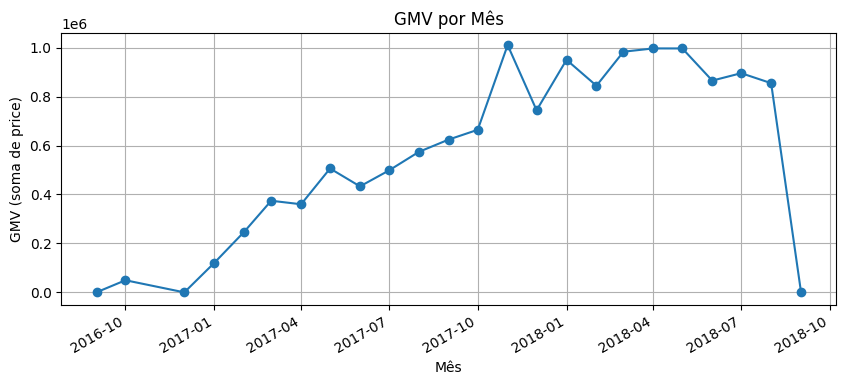

In [17]:

if 'order_purchase_timestamp' in df.columns and df['order_purchase_timestamp'].notna().any() and 'price' in df.columns:
    ts = df[['order_purchase_timestamp','price']].dropna().copy()
    ts['ano_mes'] = ts['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
    series = ts.groupby('ano_mes')['price'].sum().sort_index()
    display(series.to_frame('GMV'))
    plt.figure(figsize=(10,4))
    series.plot(marker='o')
    plt.title('GMV por Mês')
    plt.xlabel('Mês')
    plt.ylabel('GMV (soma de price)')
    plt.grid(True)
    plt.show()
else:
    print("Sem colunas suficientes para série temporal (requer order_purchase_timestamp e price).")


## Rankings de Categorias e Vendedores

Nesta etapa, o foco é identificar **quais produtos e vendedores mais contribuem para o desempenho financeiro** do negócio, por meio da análise do **GMV (Gross Merchandise Volume)** — a soma total dos valores de vendas.

A partir da tabela fato (`FATOITENSPEDIDO`) e das dimensões de **produtos (`DIMPRODUTOS`)** e **vendedores (`DIMVENDEDORES`)**, é possível construir **rankings** que destacam:
- As **categorias de produto** com maior volume de vendas total;
- Os **vendedores mais representativos** em termos de faturamento.

Essas visualizações permitem responder perguntas como:
- Quais tipos de produtos são mais rentáveis?
- Existe concentração de vendas em poucos vendedores?
- Há categorias com desempenho sazonal ou consistentemente alto?

O **ranking de categorias** auxilia na **análise de portfólio de produtos**, enquanto o **ranking de vendedores** apoia a **avaliação de performance comercial** e a **gestão de parcerias**.  
Ambos são apresentados em gráficos de barras horizontais, que facilitam a comparação visual entre as entidades e ajudam a identificar oportunidades de otimização de estratégias de venda.


,GMV
product_category_name,
beleza_saude,1258681.34
relogios_presentes,1205005.68
cama_mesa_banho,1036988.68
esporte_lazer,988048.97
informatica_acessorios,911954.32
moveis_decoracao,729762.49
cool_stuff,635290.85
utilidades_domesticas,632248.66
automotivo,592720.11


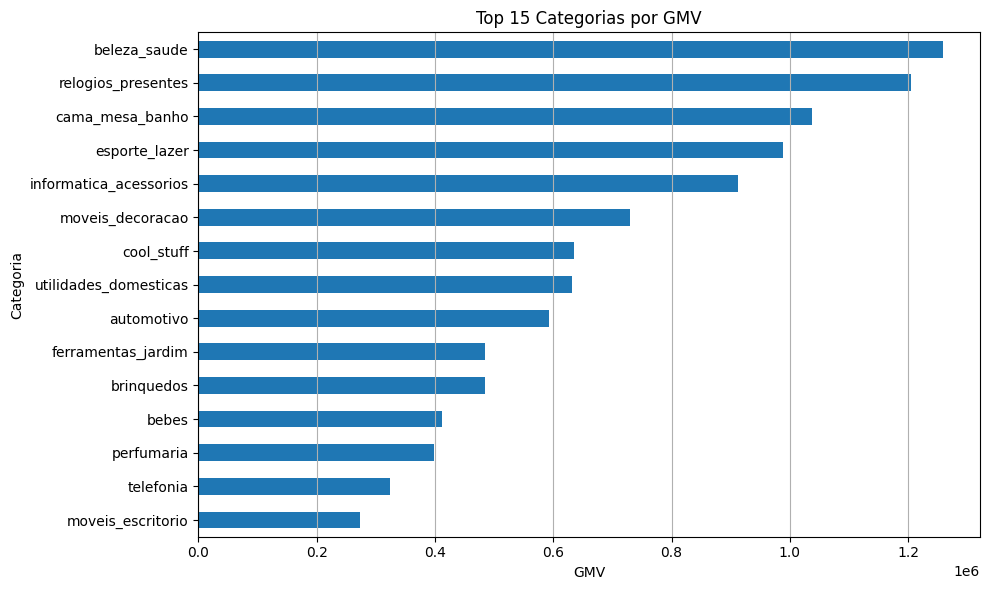

,GMV
seller_id,
4869f7a5dfa277a7dca6462dcf3b52b2,229472.63
53243585a1d6dc2643021fd1853d8905,222776.05
4a3ca9315b744ce9f8e9374361493884,200472.92
fa1c13f2614d7b5c4749cbc52fecda94,194042.03
7c67e1448b00f6e969d365cea6b010ab,187923.89
7e93a43ef30c4f03f38b393420bc753a,176431.87
da8622b14eb17ae2831f4ac5b9dab84a,160236.57
7a67c85e85bb2ce8582c35f2203ad736,141745.53
1025f0e2d44d7041d6cf58b6550e0bfa,138968.55


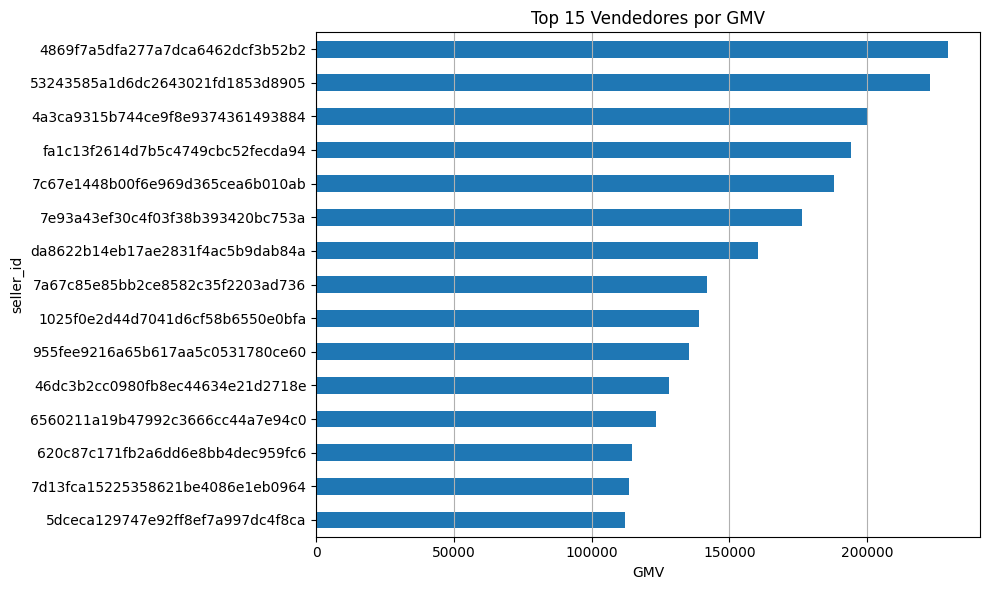

In [ ]:

if {'product_category_name','price'}.issubset(df.columns):
    top_cat = df.groupby('product_category_name')['price'].sum().sort_values(ascending=False).head(15)
    display(top_cat.to_frame('GMV'))
    plt.figure(figsize=(10,6))
    top_cat.sort_values().plot(kind='barh')
    plt.title('Top 15 Categorias por GMV')
    plt.xlabel('GMV')
    plt.ylabel('Categoria')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("Sem 'product_category_name' e 'price' para ranking de categorias.")

if {'seller_id','price'}.issubset(df.columns):
    top_seller = df.groupby('seller_id')['price'].sum().sort_values(ascending=False).head(15)
    display(top_seller.to_frame('GMV'))
    plt.figure(figsize=(10,6))
    top_seller.sort_values().plot(kind='barh')
    plt.title('Top 15 Vendedores por GMV')
    plt.xlabel('GMV')
    plt.ylabel('seller_id')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("Sem 'seller_id' e 'price' para ranking de vendedores.")


## Participação do Frete no Ticket (%)

Nesta etapa, o objetivo é compreender como o **valor do frete** se relaciona com o **valor total do produto**, analisando a proporção entre `freight_value` e `price`.  
Essa métrica, expressa em porcentagem, indica o **peso logístico do frete no preço final** de cada item, sendo fundamental para avaliar **eficiência operacional**, **competitividade de preços** e **impacto do custo de entrega** no negócio.

Para explorar o comportamento dessa variável, são utilizadas três abordagens visuais complementares:

---

### **1. Histograma — Distribuição Geral**

O **histograma** mostra como os pedidos se distribuem em diferentes faixas de porcentagem de frete.  
Cada barra representa um intervalo percentual (por exemplo, 0–10%, 10–20%, etc.), e a **altura** indica a quantidade de pedidos que possuem aquela proporção de frete em relação ao preço.  
Esse gráfico ajuda a visualizar onde está concentrada a maior parte dos casos (geralmente entre **0% e 50%**), além de revelar a presença de **outliers** — pedidos com frete muito alto.

---

### **2. Boxplot — Medidas de Dispersão e Outliers**

O **boxplot** complementa o histograma, apresentando um **resumo estatístico** da distribuição.  
Ele exibe:
- A **mediana** (linha central da caixa);
- O **intervalo interquartil (IQR)**, que cobre 50% dos casos mais comuns;
- Os **outliers**, mostrados como pontos individuais fora dos limites normais.

Essa visualização é ideal para identificar **assimetria**, **variabilidade** e **presença de fretes anômalos** (valores extremamente altos em relação ao produto).

---

### **3. Escala Logarítmica — Ampliação dos Detalhes**

Em alguns casos, há uma **concentração muito grande de pedidos com frete baixo (até 50%)** e poucos casos com frete acima de 100% ou 500%.  
Para corrigir essa distorção visual, é utilizada uma **escala logarítmica no eixo X**, que **comprime os valores altos e expande os baixos**.  
Assim, é possível visualizar toda a faixa de dados (de 0,1% a 1000%) sem que a concentração próxima de zero “esprema” o gráfico.

Essa transformação **não altera os dados**, apenas muda a forma como o eixo é representado, permitindo perceber tanto os casos típicos quanto os extremos de maneira mais equilibrada.

---

Em conjunto, esses três gráficos permitem uma análise completa da **participação do frete no ticket**, unindo:
- Frequência de ocorrência (histograma),
- Medidas estatísticas (boxplot),
- E uma visão ajustada para valores extremos (escala log).

Essa combinação facilita a tomada de decisões sobre **precificação, logística e estratégias de entrega**, tornando visível como o custo de frete se comporta em diferentes cenários de venda.


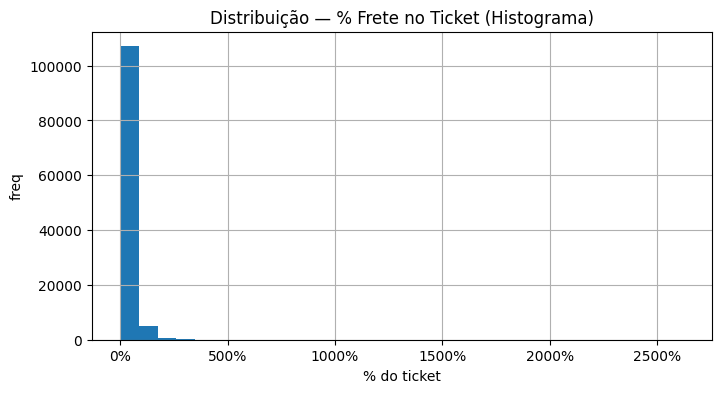

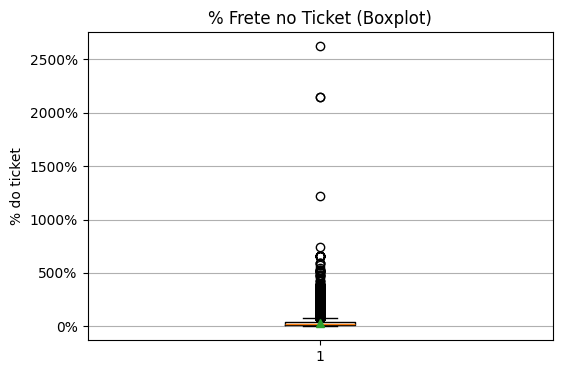

,pct_frete
count,112650.000000
mean,0.320864
std,0.349894
min,0.000000
25%,0.134034
50%,0.231356
75%,0.393036
max,26.235294


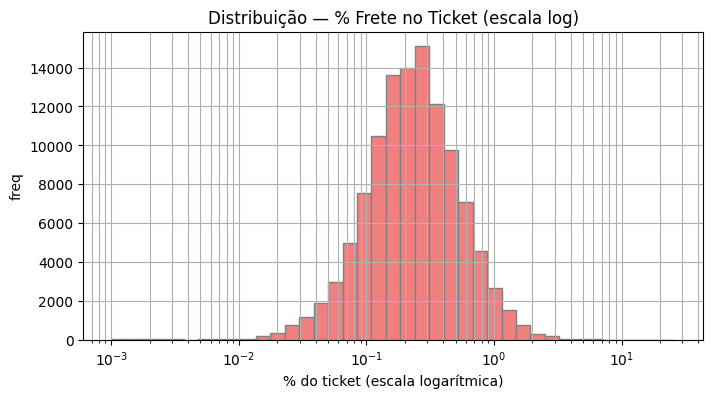

In [ ]:
if {'freight_value','price'}.issubset(df.columns):
    valid = df[df['price'] > 0].copy()
    valid['pct_frete'] = (valid['freight_value'] / valid['price']).replace([np.inf, -np.inf], np.nan)
    pct = valid['pct_frete'].dropna()

    if len(pct) > 0:
        plt.figure(figsize=(8,4))
        plt.hist(pct, bins=30)
        plt.title('Distribuição — % Frete no Ticket (Histograma)')
        plt.xlabel('% do ticket')
        plt.ylabel('freq')
        plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(6,4))
        plt.boxplot(pct, vert=True, whis=1.5, showmeans=True)
        plt.title('% Frete no Ticket (Boxplot)')
        plt.ylabel('% do ticket')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
        plt.grid(True, axis='y')
        plt.show()

        desc = pct.describe(percentiles=[.25,.5,.75])
        display(desc.to_frame('pct_frete'))
    else:
        print("Sem valores válidos para pct_frete.")
else:
    print("Sem 'freight_value' e 'price' para calcular participação do frete.")

plt.figure(figsize=(8,4))
plt.hist(pct, bins=np.logspace(np.log10(0.001), np.log10(pct.max()), 40), color='lightcoral', edgecolor='gray')
plt.xscale('log')
plt.title('Distribuição — % Frete no Ticket (escala log)')
plt.xlabel('% do ticket (escala logarítmica)')
plt.ylabel('freq')
plt.grid(True, which='both')
plt.show()

## Distribuição de Itens por Pedido (Discreto + CDF)

Nesta etapa, o objetivo é analisar o **comportamento da quantidade de itens por pedido**, uma métrica essencial para compreender **o perfil de compra dos clientes** e **a estrutura média das transações** registradas na base Silver.

Enquanto alguns pedidos podem conter apenas um item (compras simples), outros podem incluir diversos produtos, indicando **maior valor de ticket médio** ou **comportamento de compra mais diversificado**.  
Compreender essa distribuição auxilia em análises de **logística**, **precificação** e **planejamento de estoque**.

---

### **1. Gráfico Discreto — Frequência de Itens por Pedido**

O primeiro gráfico mostra, de forma discreta, **quantos pedidos possuem determinada quantidade de itens**.  
Cada barra representa um número inteiro de produtos dentro de um pedido (por exemplo, 1, 2, 3, etc.), e a altura indica **quantos pedidos** se enquadram nesse valor.

Esse tipo de visualização é ideal para variáveis **inteiras e não contínuas**, permitindo observar:
- A concentração de pedidos com poucos itens (geralmente 1 ou 2);
- A presença de pedidos maiores e mais raros;
- A forma geral da distribuição (por exemplo, assimetria à direita, típica em e-commerces).

---

### **2. CDF (Cumulative Distribution Function) — Distribuição Acumulada**

O segundo gráfico apresenta a **Curva de Distribuição Acumulada (CDF)**, que mostra a **probabilidade cumulativa de um pedido ter até *k* itens**.  
Em outras palavras:
- O eixo X mostra o número de itens por pedido (k);
- O eixo Y mostra a porcentagem de pedidos com quantidade de itens **menor ou igual** a k.

Por exemplo, se a curva atinge 0.85 em *k = 2*, significa que **85% dos pedidos possuem até dois itens**.

A CDF permite compreender rapidamente:
- Qual é o número de itens que cobre a maioria dos pedidos;
- O ponto em que a curva se estabiliza (onde praticamente todos os pedidos estão incluídos);
- O comportamento acumulado da variável sem depender de bins (faixas) como no histograma.

---

### 💡 **Interpretação Conjunta**

O **gráfico discreto** evidencia a distribuição pontual dos tamanhos de pedidos, enquanto a **CDF** fornece uma visão acumulada e mais intuitiva da concentração de frequência.  
Juntas, essas visualizações permitem identificar:
- Se o negócio é dominado por compras unitárias;
- Qual é o tamanho médio e mediano dos pedidos;
- E até onde vale a pena otimizar processos logísticos ou campanhas para incentivar pedidos maiores.

Essa análise complementa os KPIs de desempenho e ajuda a compreender melhor o **padrão de consumo dos clientes** na camada Silver.


,quantidade_de_pedidos
1,88863
2,7516
3,1322
4,505
5,204
6,198
7,22
8,8
9,3
10,8


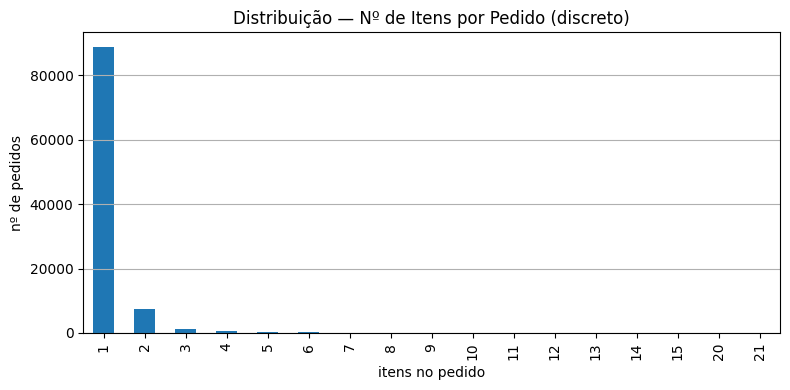

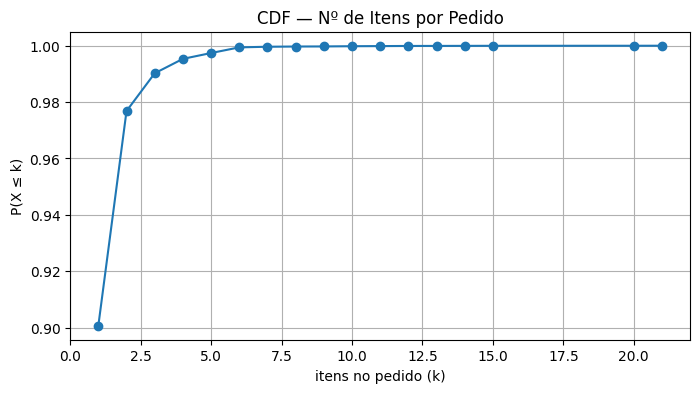

,itens_por_pedido
count,98666.000000
mean,1.141731
std,0.538452
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,21.000000


In [ ]:

if 'order_id' in df.columns:
    cnt = df.groupby('order_id').size()
    if len(cnt) > 0:
        freq = cnt.value_counts().sort_index()
        display(freq.to_frame('quantidade_de_pedidos'))

        plt.figure(figsize=(8,4))
        freq.plot(kind='bar')
        plt.title('Distribuição — Nº de Itens por Pedido (discreto)')
        plt.xlabel('itens no pedido')
        plt.ylabel('nº de pedidos')
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

        sorted_k = sorted(freq.index)
        cum = freq.cumsum() / freq.sum()
        plt.figure(figsize=(8,4))
        plt.plot(sorted_k, [cum.loc[k] for k in sorted_k], marker='o')
        plt.title('CDF — Nº de Itens por Pedido')
        plt.xlabel('itens no pedido (k)')
        plt.ylabel('P(X ≤ k)')
        plt.grid(True)
        plt.show()

        display(cnt.describe().to_frame('itens_por_pedido'))
    else:
        print("Sem pedidos para calcular distribuição.")
else:
    print("Sem 'order_id' para calcular distribuição de itens por pedido.")

## Conclusão/Síntese das Análises da Camada Silver

A partir das etapas desenvolvidas neste notebook, foi possível consolidar e explorar os principais aspectos analíticos da **Camada Silver**, transformando dados tratados do `treated_dataset.csv` em **informações estratégicas** e **visuais de apoio à decisão**.

Inicialmente, verificou-se a **estrutura efetiva do dataset**, garantindo a coerência entre as colunas presentes e o modelo dimensional planejado (Esquema em Estrela).  
Em seguida, realizou-se a **preparação das variáveis temporais**, com a criação de uma **dimensão de tempo derivada**, fundamental para análises cronológicas consistentes.

Os **KPIs de negócio** forneceram uma visão quantitativa clara sobre o desempenho operacional, permitindo observar métricas como **volume bruto de vendas (GMV)**, **participação média do frete** e **estrutura média dos pedidos**.  
As **séries temporais** e os **rankings de categorias e vendedores** complementaram essa visão, revelando **padrões sazonais**, **concentração de vendas** e **produtos mais relevantes**.

As análises visuais de **participação do frete no ticket** mostraram a importância de compreender o impacto logístico no preço final, com o uso de **histogramas, boxplots e escalas logarítmicas** para evidenciar tanto o comportamento típico quanto os outliers.  
Por fim, a distribuição de **itens por pedido** e a **curva acumulada (CDF)** destacaram a predominância de pedidos com poucos itens, característica comum em cenários de varejo digital.

Em conjunto, essas etapas demonstram o papel da Camada Silver como **ponto de equilíbrio entre dados brutos e análises de alto valor**, oferecendo uma base sólida e confiável para dashboards, relatórios gerenciais e modelos preditivos na Camada Gold.

> **Em síntese:** este notebook representa o elo analítico da arquitetura de dados; Onde a qualidade, estrutura e consistência dos dados tratados se traduzem em conhecimento de negócio acionável.
